In [73]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [74]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)

#so x is height
x, mean_x, std_x = standardize(height)

#y is weight
y, tx = build_model_data(x, weight)


In [75]:
y.shape, tx.shape

((10000,), (10000, 2))

### Ex1:
Each column of X~ represents a parameter. In this case 1's and height

Each row of X~ represents a datapoint. i.e. a persons height (as well as a 1 to multiply with w0)

We have 1's such that [1,x] * [w0,w1] always is w0+x w1

X would be 2 columns, 3 rows. Y would be 1 column, 3 rows.
X[3][2] would be third row, second colum. So the height of the 3rd person

a)
L(w) = 1/(2n) sum (yn - w0 - w1 xn1)^2

Let e = y- X~ . w = column vector where each row is (yn - w0 - w1 xn1)

e^{2} / 2n = sum((yn - w0 - w1 xn1)^2)


### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [5]:
def compute_loss(y:np.ndarray, tx:np.ndarray, w:np.ndarray):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - np.dot(tx,w)
    return np.dot(e.T,e) / (2 * tx.shape[0])
    

In [6]:
w = np.array([1,2]).T
loss = compute_loss(y,tx,w)
print(loss)



2694.4833658870853


# 2. Grid Search

Fill in the function `grid_search()` below:

In [7]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    
    for w0_index in range(len(grid_w0)):
        for w1_index in range(len(grid_w1)):
            w = np.array([grid_w0[w0_index],grid_w1[w1_index]])
            losses[w0_index][w1_index] = compute_loss(y,tx,w)
            
        
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.79354101952324, w0*=71.42857142857142, w1*=15.306122448979579, execution time=1.102 seconds


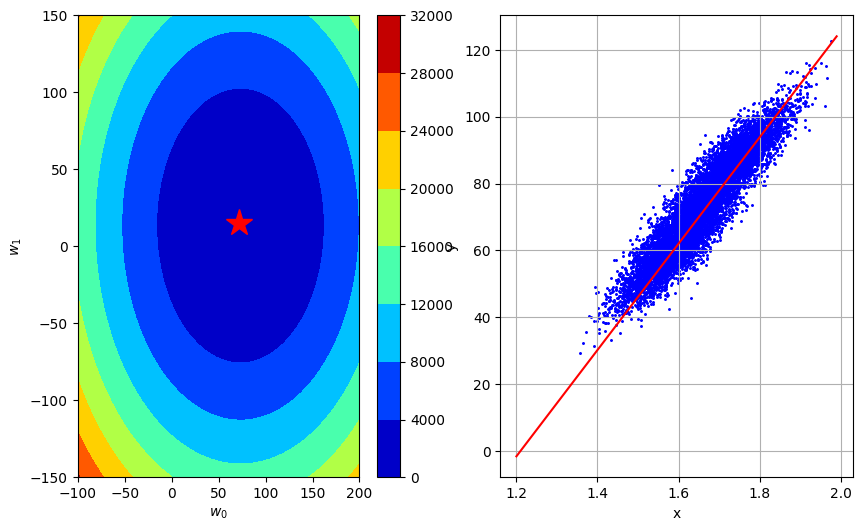

In [8]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)



# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [9]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    
    N = tx.shape[0]
    e = y - np.dot(tx,w)
    return - np.dot(tx.T,e) / N
    

In [10]:
w = np.array([100,20])
grad = compute_gradient(y,tx,w)
print(np.linalg.norm(grad))
print(grad)

w = np.array([50,10])
grad = compute_gradient(y,tx,w)
print(np.linalg.norm(grad))
print(grad)

27.490521129292492
[26.706078    6.52028757]
23.552392678247728
[-23.293922    -3.47971243]


What we see for each axis, is that the first value is too high, and the second too low. So the optimum must be between 

Please fill in the functions `gradient_descent` below:

In [29]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        
        loss = compute_loss(y,tx,w)


        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
        
        grad = compute_gradient(y,tx,w)
        w = w - gamma * grad

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [40]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1# init 0.7

# Initialization
w_initial = np.array([30, 70])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2549.8391822467825, w0=30, w1=70
GD iter. 1/49: loss=2068.293056314971, w0=34.32939220021053, w1=64.3479712434989
GD iter. 2/49: loss=1678.2406943102033, w0=38.2258451804, w1=59.261145362647916
GD iter. 3/49: loss=1362.2982810863423, w0=41.732652862570525, w1=54.68300206988202
GD iter. 4/49: loss=1106.3849263750144, w0=44.888779776524, w1=50.56267310639272
GD iter. 5/49: loss=899.095109058839, w0=47.72929399908212, w1=46.854377039252356
GD iter. 6/49: loss=731.190357032737, w0=50.28575679938443, w1=43.51691057882602
GD iter. 7/49: loss=595.1875078915946, w0=52.58657331965651, w1=40.51319076444232
GD iter. 8/49: loss=485.0252000872692, w0=54.65730818790138, w1=37.80984293149699
GD iter. 9/49: loss=395.7937307657654, w0=56.520969569321764, w1=35.37682988184619
GD iter. 10/49: loss=323.51624061534733, w0=58.19826481260011, w1=33.187118137160475
GD iter. 11/49: loss=264.9714735935089, w0=59.70783053155062, w1=31.21637756694333
GD iter. 12/49: loss=217.5502123058198, w0=

In [38]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

We can see that already after 4 iters we get a quite good fit
Loss converges to ~ 15 around there

# Changing step size
g = gamma
g = 0.001, even 50 steps is not enough
g = 0.01, still not enough 
g = 0.5, converges in 6 steps
g = 1, ONE STEP
g = 2, perpetual overstep, but stays at same loss
g = 5, perpetual overshoot, but keeps getting further from optimum

# Changing initial weight
g = 0.1

w = [0,0], ca. 40 steps
w = [100, 10], ca. 30 steps
w = [-1000,1000]

optimal w* ~= [72,13], the closer to these values the better

# 4. Stochastic gradient descent

In [139]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    
    return compute_gradient(y,tx,w)



def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    

    for n_iter in range(max_iters):
        for batch in batch_iter(y,tx, batch_size,num_batches=max_iters):
            txb = batch[1]
            yb = batch[0]
            
            loss = compute_loss(y,tx,w)
    
            # store w and loss
            ws.append(w)
            losses.append(loss)
    
            print(
                "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
                )
            )
            
            grad = compute_gradient(yb,txb,w)
            w = w - gamma * grad
        
    
 
    return losses, ws

In [142]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.01
batch_size = 10

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2869.8351145358524, w0=0, w1=0
SGD iter. 0/49: loss=2805.5770490250543, w0=0.8034854314813396, w1=0.4692907310768014
SGD iter. 0/49: loss=2743.002415119424, w0=1.5967982865368826, w1=0.9306169572974838
SGD iter. 0/49: loss=2705.5281573785105, w0=2.1766313818419776, w1=0.5061775921540586
SGD iter. 0/49: loss=2666.5178776125467, w0=2.7647057824456227, w1=0.21628982311591882
SGD iter. 0/49: loss=2603.8765950156917, w0=3.58007984479655, w1=0.6728385185721815
SGD iter. 0/49: loss=2539.5773326970307, w0=4.397971619238078, w1=1.3701443383981768
SGD iter. 0/49: loss=2476.3018119752483, w0=5.220844289333116, w1=2.04389676060536
SGD iter. 0/49: loss=2417.1467312407563, w0=6.015685465168133, w1=2.588539869059546
SGD iter. 0/49: loss=2378.9897041133936, w0=6.611246098082395, w1=2.332567947692031
SGD iter. 0/49: loss=2343.728264139692, w0=7.177124312860686, w1=2.0220267923884427
SGD iter. 0/49: loss=2306.3521166248565, w0=7.756924660096932, w1=1.8855884327275771
SGD iter. 0/49:

In [143]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=2501, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_figure(n_iter)>

#About SGD

Doesn't converge quite as nice.
Lot of tweaking to do with batch size

# 5. Effect of Outliers and MAE Cost Function

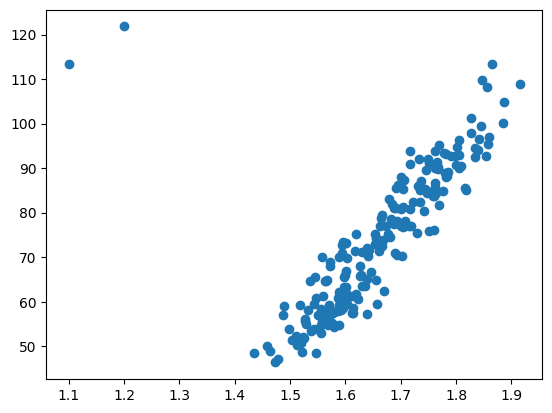

In [78]:
import datetime
from helpers import *

height, weight, _gender = load_data(sub_sample=True, add_outlier=True)


x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(height,weight)

In [79]:
y.shape, tx.shape

((202,), (202, 2))

In [80]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1# init 0.7

# Initialization
w_initial = np.array([30, 70])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))




end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2775.3582982688217, w0=30, w1=70
GD iter. 1/49: loss=2260.5670603172407, w0=34.406780585492626, w1=64.10348948659892
GD iter. 2/49: loss=1843.5861575764598, w0=38.37288311243599, w1=58.79663002453793
GD iter. 3/49: loss=1505.8316263564273, w0=41.94237538668502, w1=54.020456508683054
GD iter. 4/49: loss=1232.250456068201, w0=45.15491843350915, w1=49.72190034441366
GD iter. 5/49: loss=1010.6497081347374, w0=48.04620717565087, w1=45.853199796571204
GD iter. 6/49: loss=831.1531023086321, w0=50.64836704357842, w1=42.371369303513
GD iter. 7/49: loss=685.760851589487, w0=52.99031092471321, w1=39.23772185976061
GD iter. 8/49: loss=567.9931285069794, w0=55.098060417734516, w1=36.417439160383466
GD iter. 9/49: loss=472.6012728101481, w0=56.9950349614537, w1=33.87918473094403
GD iter. 10/49: loss=395.3338696957146, w0=58.70231205080096, w1=31.59475574444854
GD iter. 11/49: loss=332.7472731730236, w0=60.2388614312135, w1=29.5387696566026
GD iter. 12/49: loss=282.05212998964373,

In [81]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [87]:
def loss_mae(y,tx,w):
    e = y - np.dot(tx,w)
    e_abs = np.absolute(e)
    return e_abs.mean()

In [88]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    N = tx.shape[0]
    e = y - np.dot(tx,w)
    return 1/N * (np.dot(np.sign(e),tx)).T

In [89]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = loss_mae(y,tx,w)
       
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
        
        grad = compute_gradient(y,tx,w)
        w = w - gamma * grad
        

    return losses, ws

In [90]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0, w1=0
SubGD iter. 1/499: loss=22.22034175647795, w0=51.84746409844842, w1=7.724426406192425
SubGD iter. 2/499: loss=8.540676439415357, w0=67.40170332798297, w1=10.041754328050116
SubGD iter. 3/499: loss=6.904828366810239, w0=72.06797509684336, w1=10.736952704607413
SubGD iter. 4/499: loss=6.674709716875211, w0=73.46785662750146, w1=10.9455122175746
SubGD iter. 5/499: loss=6.644814813344382, w0=73.88782108669889, w1=11.00808007146475
SubGD iter. 6/499: loss=6.639117501635083, w0=74.01381042445813, w1=11.026850427631798
SubGD iter. 7/499: loss=6.6378029263688605, w0=74.0516072257859, w1=11.032481534481912
SubGD iter. 8/499: loss=6.6375033908412755, w0=74.06294626618423, w1=11.034170866536945
SubGD iter. 9/499: loss=6.637417848906233, w0=74.06634797830372, w1=11.034677666153454
SubGD iter. 10/499: loss=6.637392186325722, w0=74.06736849193958, w1=11.034829706038408
SubGD iter. 11/499: loss=6.637384487551567, w0=74.06767464603033, w1=11.034875

In [91]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

Wow, so much more robust to outliers

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [137]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    #batches = batch_iter(y,tx, batch_size,num_batches=max_iters)


    for n_iter in range(max_iters):
        for batch in batch_iter(y,tx, batch_size,num_batches=max_iters):
            txb = batch[1]
            yb = batch[0]
                        
            
            loss = loss_mae(y,tx,w)
           
            ws.append(w)
            losses.append(loss)
            
            print(
                "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
                )
            )
            
            grad = compute_gradient(yb,txb,w)
            w = w - gamma * grad
        
        
        
    return losses, ws

In [138]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/49: loss=74.06780585492638, w0=0, w1=0
SubGD iter. 0/49: loss=72.98114979263804, w0=11.343612334801762, w1=-54.66233461166405
SubGD iter. 0/49: loss=60.304852561543164, w0=23.313485767639342, w1=-44.32494490714825
SubGD iter. 0/49: loss=47.58788850532309, w0=34.4315325419296, w1=-32.662499105193135
SubGD iter. 0/49: loss=44.673064539916396, w0=39.0592282246036, w1=-31.787709088587622
SubGD iter. 0/49: loss=44.55982233544104, w0=40.196370686192594, w1=-32.48677811973297
SubGD iter. 0/49: loss=44.44762750478105, w0=40.743340407191276, w1=-32.70551052386499
SubGD iter. 0/49: loss=44.348015100713624, w0=39.36801599112809, w1=-31.501515828583404
SubGD iter. 0/49: loss=24.968545837267126, w0=51.586263766634566, w1=-7.715181249564033
SubGD iter. 0/49: loss=23.538497181030515, w0=53.86711316865661, w1=-7.545224259691599
SubGD iter. 0/49: loss=22.931972754198622, w0=55.40528227690404, w1=-7.948369107914319
SubGD iter. 0/49: loss=19.492994684938935, w0=59.13921094321944, w1=-4.6457

In [98]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>